# Least Square GAN

### Introduction

Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! [LSGAN](https://arxiv.org/abs/1611.04076) was one of the known version that aimed to improve GAN results by finding more suitable loss function.

### Learning Objectives

- Understand the difference between LSGAN and GAN
- Train LSGAN

### Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

### Imports (RUN ME!)

Make sure to run the imports cell above, otherwise the rest of the cells will fail when you try to run them. (To run a cell press `shift` + `enter` with your mouse cursor in the cell or press the play button in the top right of the cell.)

In [1]:
%load_ext tensorboard

import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt # Matplotlib is used to generate plots of data.
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np # Numpy is an efficient linear algebra library.

import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configs

In [ ]:
# Experiment paths
EXPERIMENT_ID = "train_lsGAN"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/lecture hands on lab/LSGAN/results", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')


# Data path
DATA_PATH = "/content/drive/My Drive/lecture hands on lab/datasets/cars/cars_images/"


# Model parameters
BATCH_SIZE = 64
EPOCHS = 845
LATENT_DEPTH = 100
IMAGE_SHAPE = [100,100]
NB_CHANNELS = 3
LR = 1e-4


# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.
seed = random.seed(30)

### Data understanding and exploration

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on simple image datasets used in the field of computer vision. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing focus to be put on the model architecture and image generation process itself.

We have choosen [cars dataset](https://www.kaggle.com/prondeau/the-car-connection-picture-dataset) from kaggle. It contains a lot of interior and useless images that was filtred to have 8960 diverse images with good quality ready to be used for training.

NB: with great model architecture and too little training data, GANs will overfit and will not easily converge.

In [ ]:
image_count = len(list(glob(str( DATA_PATH + '*.jpg'))))
image_count

8960

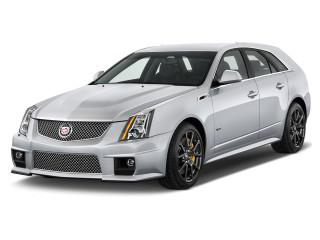

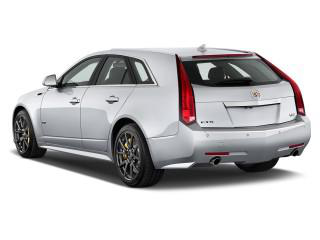

In [ ]:
cars_images_path = list(glob(str(DATA_PATH + '*.jpg')))
for image_path in cars_images_path[:2]:
    display.display(Image.open(str(image_path)))

In [ ]:
images_name = [i.split(DATA_PATH) for i in cars_images_path]
images_name = [x[:][1] for x in images_name]
cars_model = [i.split('_')[0] for i in images_name]

In [ ]:
def unique(list1): 
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    return unique_list

In [ ]:
unique_cars = unique(cars_model)
unique_cars

['Porsche',
 'Subaru',
 'Rolls-Royce',
 'BMW',
 'Tesla',
 'Volkswagen',
 'Bentley',
 'Buick',
 'Acura',
 'Chrysler',
 'Nissan',
 'Ram',
 'Audi',
 'Toyota',
 'Cadillac',
 'Alfa Romeo',
 'Aston Martin',
 'Chevrolet',
 'Volvo',
 'smart']

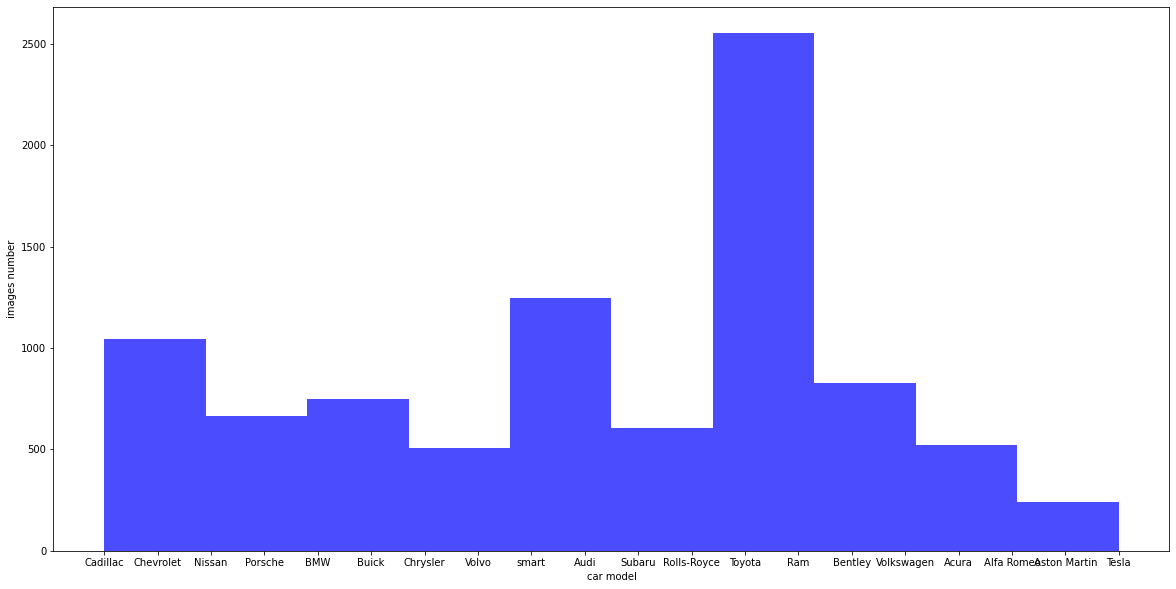

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(cars_model, color = "blue", lw=0, alpha=0.7)
plt.ylabel('images number')
plt.xlabel('car model')
plt.show()

In [ ]:
image_size = []
for filename in cars_images_path:
    im=Image.open(filename)
    im =im.size
    image_size.append(im)
print(max(image_size))
print(min(image_size))

In [ ]:
# Read in the image
image = mpimg.imread(cars_images_path[20])

plt.axis("off")
plt.imshow(image)

##### Let's take a look on the different channel axis views of the image (the red, green and blue channels)

In [ ]:
# Isolate RGB channels
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

The dataset contains 8960 images:
* Three-channel each one.
* Diverse styles
* the minimum shape is (320, 124)
* the maximum shape is (320, 360)

### Data Loader

For the Data pipeline, I will show you two versions. The first one will be using Data API provide it by TensorFlow. What we have to do is create a dataset object, tell it where to get the data, then transform it in any way we want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.\
(1) Create dataset entirely in RAM using tf.data.Dataset.from_tensor_slices() \
(2) Call shuffle to ensure that the training set are independent and identically distributed. \
NB:  the buffer size must be specified, and it is important to make it large enough or else shuffling will not be very efficient.\
(3) Do the necessary transformation by calling the map() method. \
(4) Call the batch() method. It will group the items of the previous dataset in batches of n items. \
(5) Using prefetch will let the dataset work on parallel with training algorithm to get the next batch ready.
![alt text](https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC)

The second version will be using PIL to read the image and do the resizing. The main differences are:
- PIL is time-consuming. It takes multiple 4 the time it takes Tensorflow.
- PIL is the best in keeping image quality while resizing the image. Because The `resize()` function doesn't modify the used image, it instead returns another Image with the new dimensions.

In production, we sometimes sacrifice the quality and tend to get results more quickly. Eventually, we will have the quality but after tunning and many experiences.

We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1] or [0,1]. But you should know that if you're using [-1,1] you need to choose tanh as an activation function and if you are normalizing to [0,1] you use sigmoid activation function.

### Data Loader using TF API

In [ ]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [ ]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
dataset = dataloader(cars_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

### Data Loader using PIL

In [ ]:
image_list = []
for filename in cars_images_path:
    im=Image.open(filename)
    im =im.resize((IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
    image_list.append(im)

In [ ]:
images_processed = []
for image in image_list:
    gan_train_images = np.asarray(image)
    gan_train_images = gan_train_images.astype('float32') /255.0
    images_processed.append(gan_train_images)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(images_processed).shuffle(10* BATCH_SIZE).batch(BATCH_SIZE)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

# Modeling

### Generator


![Generator.png](https://drive.google.com/uc?export=view&id=1R14EtpJXZo_kKWJSsUqUPPdLgZ_phMhV)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((25, 25, 128)))
    assert model.output_shape == (None, 25, 25, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 100, 100, 3)
    model.summary()
    return model

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, LATENT_DEPTH])
generated_image = generator(noise, training=True)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

### Discriminator


![Discriminator.png](https://drive.google.com/uc?export=view&id=1AUwLeBvtGLnnoMx6m-xXi9Aq4LuQjaOp)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3]))
    model.add(layers.ReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()
    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

## Loss and Optimization

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=LR)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LR)

The model is trained to minimize [MeanSquaredError](https://rohanvarma.me/Loss-Functions/)

In [ ]:
mse = tf.losses.MeanSquaredError()

In [ ]:
def discriminator_loss(r_logit, f_logit):
    r_loss = mse(tf.ones_like(r_logit), r_logit)
    f_loss = mse(tf.zeros_like(f_logit), f_logit)
    loss_total = r_loss + f_loss
    return loss_total

In [ ]:
def generator_loss(f_logit):
    f_loss = mse(tf.ones_like(f_logit), f_logit)
    return f_loss

## Experiment utils (RUN ME)

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        tf.summary.trace_on(graph=False, profiler=True)
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
            tf.summary.trace_export(
              name="trace",
              step=0,
              profiler_outdir=MODEL_SAVE_PATH
            )
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)
            tf.summary.trace_export(
              name="trace",
              step=0,
              profiler_outdir=MODEL_SAVE_PATH
            )
    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(EXPERIMENT_ID, 'summaries', 'train'))
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_and_save_images(model, epoch):
    
    plt.figure(figsize=(15,10))

    for i in range(4):
        noise = tf.random.normal([1,100]) - 1 + (i * 0.2) + 0.1 
        images = model(noise, training=False)
        
        image = images[0, :, :, :]
        image = np.reshape(image, [100, 100, 3])

        plt.subplot(1, 4, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title("Randomly Generated Images")

    plt.tight_layout()  
    plt.savefig(os.path.join(MODEL_SAVE_PATH,'image_at_epoch_{:02d}.png'.format(epoch)))
    plt.show()

## Training Process

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DEPTH])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return {'Generator loss': gen_loss,
            'Discriminator loss': disc_loss}

In [ ]:
def train(dataset, epochs):
    tf.summary.trace_on(graph=False, profiler=True)
    with train_summary_writer.as_default():
        with tf.summary.record_if(True):
            for epoch in range(epochs):
                start = time.time()
                for image_batch in dataset:
                    loss_dict = train_step(image_batch)
                summary(loss_dict, step=generator_optimizer.iterations, name='losses')

                display.clear_output(wait=True)
                generate_and_save_images(generator,
                                        epoch + 1)
                # Save the model every 15 epochs
                if (epoch + 1) % 15 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs)

In [6]:
%tensorboard --logdir='/content/drive/My Drive/lecture hands on lab/LSGAN/results'

In [ ]:
train(dataset, EPOCHS)

### Generate Gif with the whole generated images during training

In [1]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

# Congratulations!
you have built your first Least Square GAN

### Suggestion tasks for practice

* Play arround with the model architecture
* Play arround with optimizer
* Tuning the hyperparameters
  - Learning rate
  - Batch size
  - Number of epochs
  - Generator optimizer
  - Discriminator optimizer
  - Number of layers
  - Number of units in a dense layer
  - Activation function
* Observe the discriminator and generator loss failure and image generation failure using tensorboard
* See this [github](https://github.com/soumith/ganhacks) repo that contains a set of 17 hacks that are useful for getting models working
* Try [hinge loss](https://rohanvarma.me/Loss-Functions/)

In [ ]:
## Solution for hinge loss
def discriminator_loss(r_logit, f_logit):
    r_loss = tf.reduce_mean(tf.maximum(1 - r_logit, 0))
    f_loss = tf.reduce_mean(tf.maximum(1 + f_logit, 0))
    return r_loss, f_loss

def generator_loss(f_logit):
    f_loss = tf.reduce_mean(- f_logit)
    return f_loss